base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу.

In [1]:
import pandas as pd
import numpy as np
import faiss
import zipfile
import itertools
import requests
import io
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import optuna
from phik import resources, report
from phik.report import plot_correlation_matrix
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
# Функция для получения прямой ссылки на скачивание
def get_direct_download_link(public_url):
    api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key='
    download_url = api_url + public_url
    response = requests.get(download_url)
    if response.status_code == 200:
        return response.json()['href']
    else:
        response.raise_for_status()

# Публичная ссылка на файл
public_url = 'https://disk.yandex.ru/d/S5YufXZN_R1x8A'

# Получаем прямую ссылку для скачивания
direct_download_url = get_direct_download_link(public_url)

# Скачиваем ZIP-файл
response = requests.get(direct_download_url)
if response.status_code == 200:
    print("Файл успешно скачан.")
else:
    print("Не удалось скачать файл.")
    response.raise_for_status()

# Открываем загруженный ZIP-файл из потока
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    # Выводим список файлов в архиве для проверки
    print("Список файлов в архиве:", zip_ref.namelist())
    
    # Читаем файлы непосредственно из архива и устанавливаем 'Id' в качестве индекса
    with zip_ref.open('base.csv') as base_file:
        base = pd.read_csv(base_file, index_col='Id')
    with zip_ref.open('train.csv') as train_file:
        train = pd.read_csv(train_file, index_col='Id')
    with zip_ref.open('validation.csv') as validation_file:
        validation = pd.read_csv(validation_file, index_col='Id')
    with zip_ref.open('validation_answer.csv') as validation_answer_file:
        validation_answer = pd.read_csv(validation_answer_file, index_col='Id')

# Теперь переменные base, train, validation и validation_answer содержат данные из соответствующих CSV-файлов с 'Id' в качестве индекса

Файл успешно скачан.
Список файлов в архиве: ['base.csv', 'train.csv', 'validation.csv', 'validation_answer.csv']


In [3]:
# Предварительный анализ данных
for df, name in zip([base, train, validation, validation_answer], ['Base', 'Train', 'Validation', 'Validation Answer']):
    print(f"--- {name} Dataset ---")
    print("Первые 5 строк:")
    display(df.head())
    print("\nОсновная информация:")
    df.info()
    print("\nСтатистическая информация:")
    display(df.describe())
    print("\n")

--- Base Dataset ---
Первые 5 строк:


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,...,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,...,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,...,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,...,-30.002094,53.642930,-149.823230,176.921371,69.473280,-43.395180,-58.947716,133.84064,-1074.464888,-1.164146



Основная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float64
 1   1       291813 non-null  float64
 2   2       291813 non-null  float64
 3   3       291813 non-null  float64
 4   4       291813 non-null  float64
 5   5       291813 non-null  float64
 6   6       291813 non-null  float64
 7   7       291813 non-null  float64
 8   8       291813 non-null  float64
 9   9       291813 non-null  float64
 10  10      291813 non-null  float64
 11  11      291813 non-null  float64
 12  12      291813 non-null  float64
 13  13      291813 non-null  float64
 14  14      291813 non-null  float64
 15  15      291813 non-null  float64
 16  16      291813 non-null  float64
 17  17      291813 non-null  float64
 18  18      291813 non-null  float64
 19  19      291813 non-null  float64
 20  20      291813 

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,...,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000
mean,-86.274741,8.078087,-44.613480,-146.605552,111.261183,-71.875015,-393.430460,20.391975,123.676692,124.427158,...,-79.075207,33.244836,-154.720293,13.699277,67.792659,23.543147,74.890028,115.611366,-798.355219,-47.701336
std,24.918947,4.949495,38.545928,19.842726,46.350083,28.189743,272.084921,64.297194,6.352832,64.366631,...,30.485074,28.896144,41.217568,98.996416,1.825081,55.353032,61.320347,21.219222,385.414338,41.731025
min,-189.356020,-12.594500,-231.785920,-224.880500,-95.240830,-188.473330,-791.468770,-296.171050,93.684616,-143.499600,...,-214.821140,-85.825500,-346.239320,-157.593866,59.835790,-213.492420,-190.483150,18.601448,-1297.924962,-209.935760
25%,-103.154300,4.709408,-69.535900,-159.882740,80.367640,-91.227936,-631.937855,-22.085905,119.473625,81.685610,...,-98.823830,16.952824,-180.695560,-71.763964,66.582790,-12.501141,33.784820,101.675660,-1074.464888,-75.621110
50%,-86.308130,8.040010,-43.838493,-146.717360,111.776870,-71.751820,-424.306925,20.850153,123.882500,123.456270,...,-78.538180,34.682540,-153.902830,13.167371,67.815050,23.461630,74.876980,116.049270,-1074.464888,-48.403816
75%,-69.254616,11.466815,-19.694052,-133.320140,142.364610,-52.310825,-157.342700,63.989326,127.967766,167.014130,...,-58.638412,52.097710,-127.221360,99.362213,69.028800,59.740337,115.896880,129.625950,-504.291183,-19.684170
max,15.574616,28.751917,151.377080,-55.167892,299.307920,49.880882,109.631986,301.094240,147.870910,402.994600,...,48.822197,141.025270,17.344528,185.096719,75.474625,264.347200,319.601040,213.577260,98.770811,126.973220




--- Train Dataset ---
Первые 5 строк:


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,...,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,...,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,...,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,...,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,...,13.807772,-208.650040,41.742014,66.522420,41.362930,162.723050,111.261310,-151.162805,-33.831450,168591-base



Основная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9999 non-null   float64
 1   1       9999 non-null   float64
 2   2       9999 non-null   float64
 3   3       9999 non-null   float64
 4   4       9999 non-null   float64
 5   5       9999 non-null   float64
 6   6       9999 non-null   float64
 7   7       9999 non-null   float64
 8   8       9999 non-null   float64
 9   9       9999 non-null   float64
 10  10      9999 non-null   float64
 11  11      9999 non-null   float64
 12  12      9999 non-null   float64
 13  13      9999 non-null   float64
 14  14      9999 non-null   float64
 15  15      9999 non-null   float64
 16  16      9999 non-null   float64
 17  17      9999 non-null   float64
 18  18      9999 non-null   float64
 19  19      9999 non-null   float64
 20  20      9999 non-null   float64
 21  21

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,...,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,-85.469569,7.608015,-43.886495,-146.204146,111.979577,-73.679417,-443.890756,21.820551,123.107400,126.418041,...,-81.373935,37.137381,-152.473803,16.533799,67.803505,23.750006,73.254974,115.410518,-708.824875,-48.325315
std,25.986217,4.985728,39.318615,20.309633,47.599872,28.743810,281.494323,66.450440,6.418815,64.858194,...,30.628554,25.391546,41.109706,98.956198,1.875665,54.838217,61.459193,21.641422,405.686503,40.899658
min,-173.032560,-11.560507,-187.292630,-219.724800,-71.243350,-184.962450,-791.443909,-250.681340,99.001770,-113.104600,...,-191.308230,-60.515068,-306.837650,-157.579209,61.339855,-165.361250,-127.017555,34.696030,-1297.871984,-208.276810
25%,-103.445763,4.178606,-69.990780,-160.032880,79.712390,-93.620305,-757.628755,-21.344349,118.787718,81.959692,...,-101.775513,20.369431,-179.337380,-67.498388,66.534668,-12.360923,32.034007,100.510068,-1074.464888,-75.271170
50%,-85.177100,7.592032,-43.009907,-146.576220,112.233475,-74.031080,-517.673347,22.233670,123.002785,126.280350,...,-81.767230,36.944336,-151.394590,16.007951,67.819710,24.146404,73.178340,115.813060,-800.296677,-49.027412
75%,-67.437850,10.989736,-17.223701,-132.675850,144.052645,-54.168713,-203.437622,66.437385,127.499309,169.959880,...,-60.619155,53.901959,-124.285235,101.773980,69.086705,59.301756,113.039340,130.225600,-362.486812,-21.845187
max,5.052292,26.741890,134.859800,-71.194680,297.368620,31.378914,109.632035,261.413420,145.178470,353.214970,...,20.978668,137.559200,-18.955208,185.055845,74.121605,236.385470,304.391780,187.621400,97.787799,111.831955




--- Validation Dataset ---
Первые 5 строк:


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,108.809586,...,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,95.231290,...,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,59.321335,...,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,201.146090,...,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,131.900620,...,-116.440605,47.279976,-162.65400,107.409409,67.78526,-60.976490,142.68571,82.264300,-345.340457,-48.572525



Основная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  2

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-85.307362,7.633750,-43.686537,-146.038791,111.209942,-72.767940,-440.587163,21.834861,123.051767,124.662559,...,-81.250167,36.956902,-152.122730,14.886141,67.791824,22.857614,72.524486,115.420796,-709.333484,-49.022258
std,25.911681,4.950078,38.805284,20.543489,47.779448,28.617899,278.953671,66.326518,6.522882,65.458934,...,30.617505,25.251097,40.945219,99.384247,1.851120,55.658492,62.595136,21.490729,405.917480,41.159872
min,-167.550670,-10.583933,-205.797360,-219.720890,-76.422760,-170.868380,-791.443909,-277.983950,97.360535,-118.700714,...,-189.231300,-47.206474,-308.200380,-157.580677,61.086390,-174.799100,-159.840730,27.746750,-1297.689518,-209.935760
25%,-103.253996,4.245802,-69.606605,-159.972975,78.592808,-92.371089,-739.549115,-22.112910,118.623887,81.167942,...,-101.935440,19.950575,-178.986322,-71.481630,66.545755,-14.034864,31.120448,100.431221,-1074.464888,-76.834515
50%,-85.495230,7.604729,-43.152172,-146.100195,111.398595,-72.734217,-512.600719,22.596903,123.105532,124.588370,...,-80.640330,36.343388,-151.159155,16.498258,67.809390,22.756214,71.640040,115.465535,-809.193143,-49.420510
75%,-67.228041,10.950509,-17.883776,-131.973093,143.645965,-53.415469,-204.531443,67.179237,127.583330,168.550240,...,-60.179952,53.856120,-124.446027,100.077341,69.043971,60.188393,114.197410,129.996610,-358.197327,-20.995152
max,10.861183,27.944784,107.040690,-73.909584,287.397200,47.001106,109.404851,251.090180,146.034410,350.088320,...,31.880241,141.025270,-17.406784,184.987267,73.886790,241.695620,289.583160,190.171420,98.747128,102.473755




--- Validation Answer Dataset ---
Первые 5 строк:


,Expected
Id,
196680-query,1087368-base
134615-query,849674-base
82675-query,4183486-base
162076-query,2879258-base
23069-query,615229-base



Основная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Expected  10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB

Статистическая информация:


,Expected
count,10000
unique,9640
top,935520-base
freq,3


In [4]:
# Проверка на дубликаты и их удаление
for df, name in zip([base, train], ['Base', 'Train']):
    print(f"--- {name} Dataset ---")
    if df.duplicated().any():
        print("Обнаружены дубликаты!")
        print("Количество дубликатов до удаления:", df.duplicated().sum())
        df.drop_duplicates(inplace=True)
        print("Дубликаты удалены.")
        print("Количество дубликатов после удаления:", df.duplicated().sum())
    else:
        print("Дубликаты не обнаружены.")
    print("\n")


--- Base Dataset ---
Обнаружены дубликаты!
Количество дубликатов до удаления: 11278
Дубликаты удалены.
Количество дубликатов после удаления: 0


--- Train Dataset ---
Обнаружены дубликаты!
Количество дубликатов до удаления: 243
Дубликаты удалены.
Количество дубликатов после удаления: 0




c:\Users\ivano\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Target is large: 9672. Are you sure this is not an interval variable? Analysis for pairs of variables including Target can be slow.
  warnings.warn(


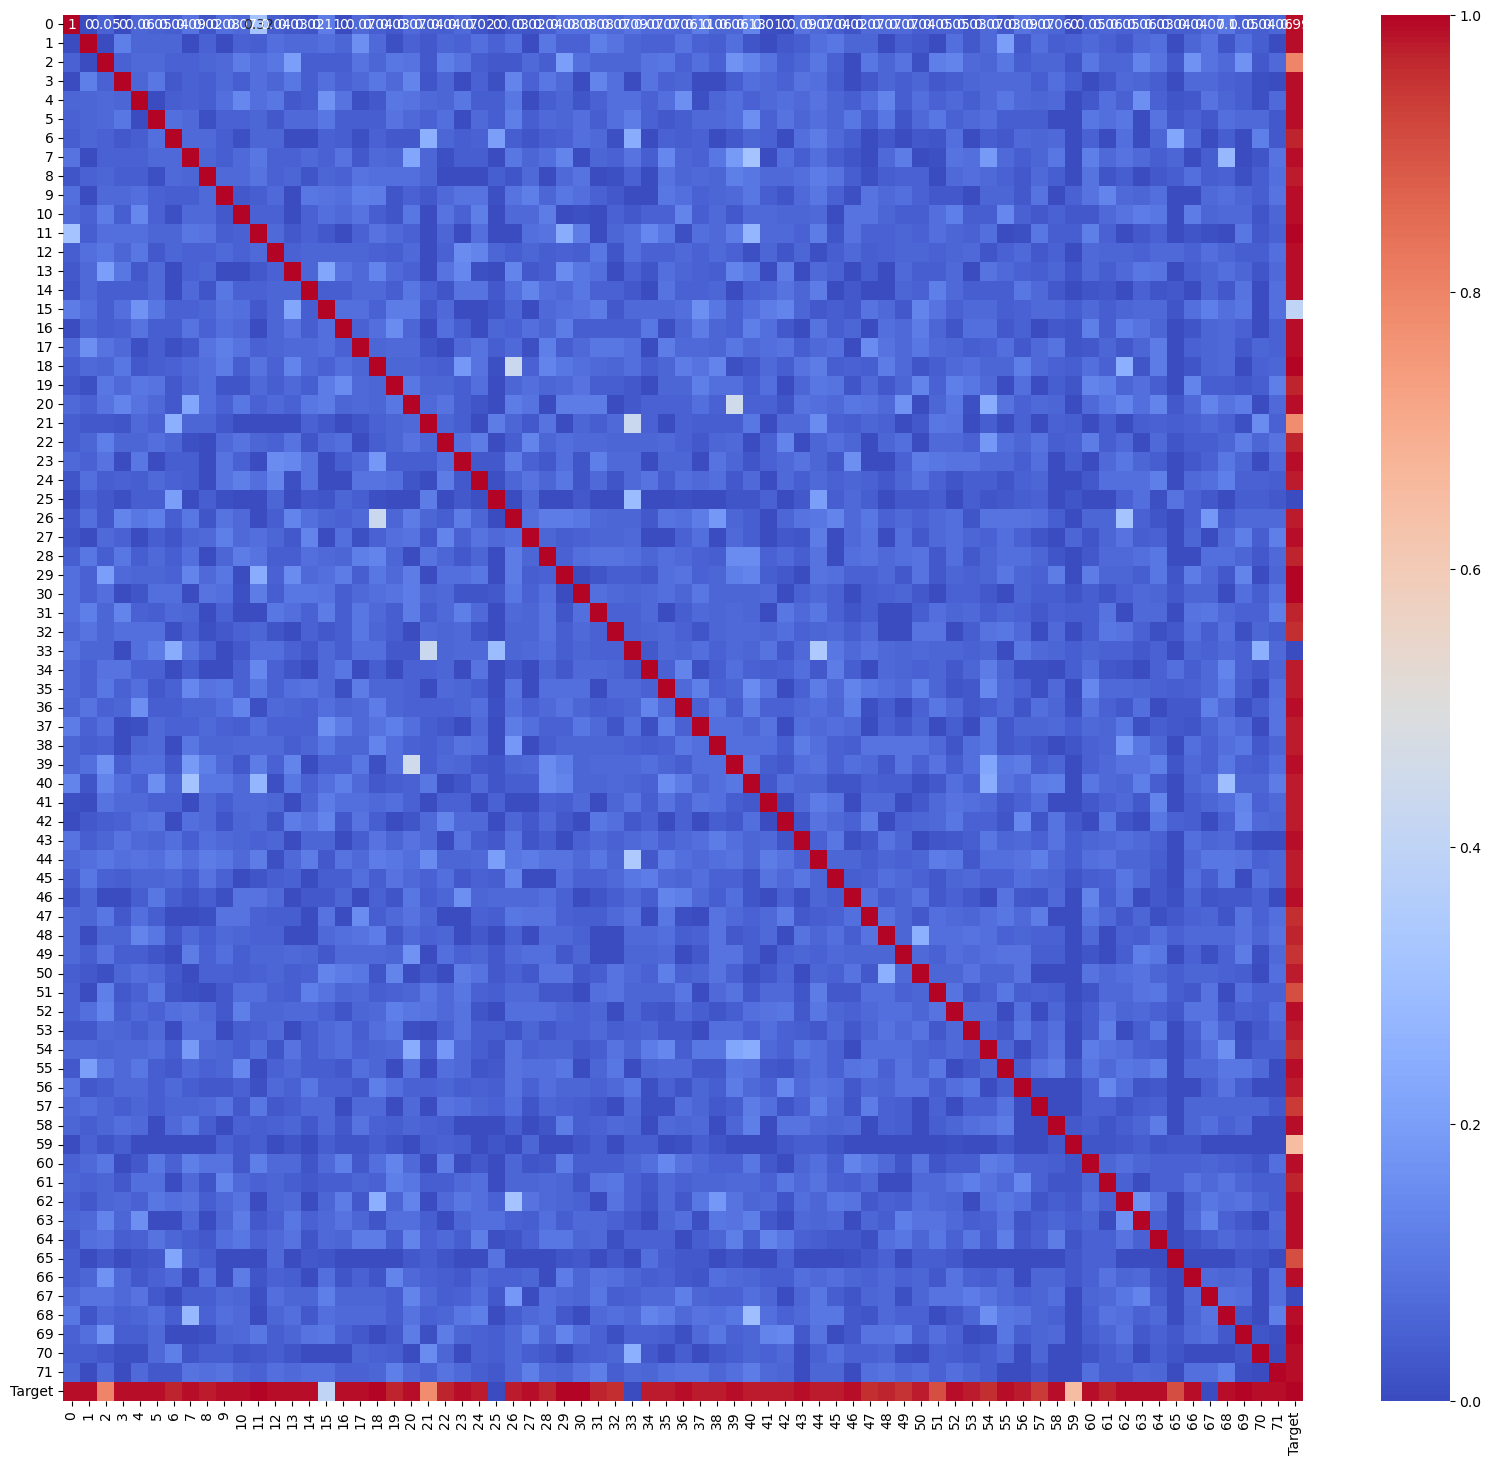

In [5]:
# Получаем список всех колонок, кроме 'Target'
interval_cols = train.columns.tolist()
interval_cols.remove('Target')

# Рассчитываем матрицу корреляции phik, исключая 'Target' из интервальных колонок
phik_matrix = train.phik_matrix(interval_cols=interval_cols)

# Округляем значения в матрице до двух знаков после запятой
phik_matrix_rounded = phik_matrix.round(2)

# Выводим тепловую карту матрицы корреляции
# Увеличиваем размер графика для лучшего отображения всех признаков
plt.figure(figsize=(20, 18))
sns.heatmap(phik_matrix_rounded, annot=True, cmap='coolwarm')
plt.show()


In [6]:
# Определяем порог корреляции
correlation_threshold = 0.3

# Найдим признаки, которые слабо коррелируют с 'Target'
low_corr_features = phik_matrix_rounded[abs(phik_matrix_rounded['Target']) < correlation_threshold].index

# Удаляем эти признаки из датасета 'train'
train = train.drop(low_corr_features, axis=1)

# Удаляем эти же признаки из датасета 'base'
base = base.drop(low_corr_features, axis=1)



In [7]:
low_corr_features

Index(['25', '33', '67'], dtype='object')

In [8]:

# Фиксируем столбец "Target" в переменную targets
targets = train["Target"]

# Удаляем столбец "Target" из тренировочного набора данных
train.drop("Target", axis=1, inplace=True)


In [9]:
# Определяем размерность данных на основе количества столбцов в наборе данных base
dims = base.shape[1]

# Задаем количество кандидатов для поиска
candidate_number = 5 

def objective(trial):
    # Определяем параметры для оптимизации
    n_cells = trial.suggest_int('n_cells', 10, 500)
    nprobe = trial.suggest_int('nprobe', 2, 100)
    quantizer_type_str = trial.suggest_categorical('quantizer_type', ['IndexFlatL2', 'IndexFlatIP'])
    index_type_str = trial.suggest_categorical('index_type', ['IndexIVFFlat'])
    scaler_str = trial.suggest_categorical('scaler', ['StandardScaler', 'RobustScaler'])

    # Преобразуем строки обратно в типы
    quantizer_type = getattr(faiss, quantizer_type_str)
    index_type = getattr(faiss, index_type_str)
    scaler_type = getattr(sklearn.preprocessing, scaler_str)

    # Создаем экземпляр масштабировщика и применяем его к тренировочным и базовым данным
    scaler = scaler_type()
    base_scaled = pd.DataFrame(scaler.fit_transform(base), columns=base.columns, index=base.index)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns, index=train.index)

    # Создаем квантизатор
    quantizer = quantizer_type(dims)
    
    # Создаем индекс
    idx = index_type(quantizer, dims, n_cells)
    
    # Устанавливаем параметр nprobe
    idx.nprobe = nprobe
    
    # Обучаем индекс
    idx.train(np.ascontiguousarray(base_scaled.values).astype('float32'))
    idx.add(np.ascontiguousarray(base_scaled.values).astype('float32'))
    
    # Выполняем поиск ближайших соседей
    _, idx_nearest = idx.search(np.ascontiguousarray(train_scaled.values).astype('float32'), candidate_number)
    
    # Создаем словарь для сопоставления индексов данных с их первоначальными индексами из DataFrame base
    base_index = {k: v for k, v in enumerate(base.index.to_list())}
    
    # Вычисляем точность
    accuracy = sum(int(target in [base_index[r] for r in el]) for target, el in zip(targets.values.tolist(), idx_nearest.tolist())) / len(idx_nearest)
    
    return accuracy

class EarlyStoppingCallback:
    def __init__(self, patience):
        self.patience = patience
        self.best_value = None
        self.best_trial = None
        self.stopped_trial = None

    def __call__(self, study, trial):
        if study.best_trial != self.best_trial:
            self.best_trial = study.best_trial
            self.stopped_trial = 0
        else:
            self.stopped_trial += 1
        if self.stopped_trial >= self.patience:
            study.stop()

# Создаем экземпляр стадии с фиксированным seed
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=13))

# Создаем обратный вызов для ранней остановки
early_stop_callback = EarlyStoppingCallback(patience=10)

# Запускаем оптимизацию с обратным вызовом для ранней остановки
study.optimize(objective, n_trials=100, callbacks=[early_stop_callback])

# Выводим лучший результат и соответствующие параметры
print(f"Лучший результат: точность = {study.best_value:.1%}, параметры: {study.best_params}")

# Сохраняем результаты оптимизации
study.trials_dataframe().to_csv('optimization_results.csv')

[I 2024-05-25 04:17:00,172] A new study created in memory with name: no-name-a1fb1f34-196d-4878-ad49-f34c073761fc
[I 2024-05-25 04:17:30,051] Trial 0 finished with value: 0.7742927429274292 and parameters: {'n_cells': 391, 'nprobe': 25, 'quantizer_type': 'IndexFlatIP', 'index_type': 'IndexIVFFlat', 'scaler': 'StandardScaler'}. Best is trial 0 with value: 0.7742927429274292.
[I 2024-05-25 04:17:57,182] Trial 1 finished with value: 0.7773677736777368 and parameters: {'n_cells': 309, 'nprobe': 78, 'quantizer_type': 'IndexFlatIP', 'index_type': 'IndexIVFFlat', 'scaler': 'RobustScaler'}. Best is trial 1 with value: 0.7773677736777368.
[I 2024-05-25 04:18:29,888] Trial 2 finished with value: 0.781980319803198 and parameters: {'n_cells': 38, 'nprobe': 86, 'quantizer_type': 'IndexFlatIP', 'index_type': 'IndexIVFFlat', 'scaler': 'RobustScaler'}. Best is trial 2 with value: 0.781980319803198.
[I 2024-05-25 04:19:01,772] Trial 3 finished with value: 0.781980319803198 and parameters: {'n_cells': 1

Лучший результат: точность = 78.5%, параметры: {'n_cells': 79, 'nprobe': 91, 'quantizer_type': 'IndexFlatIP', 'index_type': 'IndexIVFFlat', 'scaler': 'StandardScaler'}


In [10]:
# Удаляем столбец "Target" из валидационного набора данных
validation = validation.drop(low_corr_features, axis=1)

In [11]:
# Задаем параметры
n_cells = 79
nprobe = 91
quantizer_type_str = 'IndexFlatIP'
index_type_str = 'IndexIVFFlat'
scaler_str = 'StandardScaler'

# Преобразуем строки обратно в типы
quantizer_type = getattr(faiss, quantizer_type_str)
index_type = getattr(faiss, index_type_str)
scaler_type = getattr(sklearn.preprocessing, scaler_str)

# Создаем экземпляр масштабировщика и применяем его к базовым и валидационным данным
scaler = scaler_type()
base_scaled = pd.DataFrame(scaler.fit_transform(base), columns=base.columns, index=base.index)
validation_scaled = pd.DataFrame(scaler.transform(validation), columns=validation.columns, index=validation.index)

# Создаем квантизатор
quantizer = quantizer_type(dims)

# Создаем индекс
idx = index_type(quantizer, dims, n_cells)

# Устанавливаем параметр nprobe
idx.nprobe = nprobe

# Обучаем индекс
idx.train(np.ascontiguousarray(base_scaled.values).astype('float32'))
idx.add(np.ascontiguousarray(base_scaled.values).astype('float32'))

# Выполняем поиск ближайших соседей
_, idx_nearest = idx.search(np.ascontiguousarray(validation_scaled.values).astype('float32'), candidate_number)

# Создаем словарь для сопоставления индексов данных с их первоначальными индексами из DataFrame base
base_index = {k: v for k, v in enumerate(base.index.to_list())}

# Вычисляем точность
accuracy = sum(int(target in [base_index[r] for r in el]) for target, el in zip(validation_answer['Expected'].values.tolist(), idx_nearest.tolist())) / len(idx_nearest)

print(f"Точность на валидационных данных: {accuracy:.1%}")

Точность на валидационных данных: 77.7%


In [12]:
# Функция для получения прямой ссылки на скачивание
def get_direct_download_link(public_url):
    api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key='
    download_url = api_url + public_url
    response = requests.get(download_url)
    if response.status_code == 200:
        return response.json()['href']
    else:
        response.raise_for_status()

# Публичная ссылка на файл
public_url = 'https://disk.yandex.ru/d/eBvMC0tN1kSSAg'

# Получаем прямую ссылку для скачивания
direct_download_url = get_direct_download_link(public_url)

# Скачиваем ZIP-файл
response = requests.get(direct_download_url)
if response.status_code == 200:
    print("Файл успешно скачан.")
else:
    print("Не удалось скачать файл.")
    response.raise_for_status()

# Открываем загруженный ZIP-файл из потока
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    # Выводим список файлов в архиве для проверки
    print("Список файлов в архиве:", zip_ref.namelist())
    
    # Читаем файлы непосредственно из архива и устанавливаем 'Id' в качестве индекса
    with zip_ref.open('base.csv') as base_file:
        base = pd.read_csv(base_file, index_col='Id')
    with zip_ref.open('validation.csv') as validation_file:
        validation = pd.read_csv(validation_file, index_col='Id')
    with zip_ref.open('validation_answer.csv') as validation_answer_file:
        validation_answer = pd.read_csv(validation_answer_file, index_col='Id')

Файл успешно скачан.
Список файлов в архиве: ['base.csv', 'train.csv', 'validation.csv', 'validation_answer.csv']


In [13]:
# Удаляем ненужные признаки из датасета 'base'
base = base.drop(low_corr_features, axis=1)

# Удаляем ненужные признаки из валидационного набора данных
validation = validation.drop(low_corr_features, axis=1)

In [14]:
import time
import numpy as np

# Задаем параметры
n_cells = 79
nprobe = 91
quantizer_type_str = 'IndexFlatIP'
index_type_str = 'IndexIVFFlat'
scaler_str = 'StandardScaler'

# Преобразуем строки обратно в типы
quantizer_type = getattr(faiss, quantizer_type_str)
index_type = getattr(faiss, index_type_str)
scaler_type = getattr(sklearn.preprocessing, scaler_str)

# Создаем экземпляр масштабировщика и применяем его к базовым и валидационным данным
start_time = time.time()
scaler = scaler_type()
base_scaled = pd.DataFrame(scaler.fit_transform(base), columns=base.columns, index=base.index)
validation_scaled = pd.DataFrame(scaler.transform(validation), columns=validation.columns, index=validation.index)
print(f"Масштабирование данных заняло {time.time() - start_time} секунд")

# Создаем квантизатор
start_time = time.time()
quantizer = quantizer_type(dims)
print(f"Создание квантизатора заняло {time.time() - start_time} секунд")

# Создаем индекс
start_time = time.time()
idx = index_type(quantizer, dims, n_cells)
print(f"Создание индекса заняло {time.time() - start_time} секунд")

# Устанавливаем параметр nprobe
idx.nprobe = nprobe

# Обучаем индекс
start_time = time.time()
idx.train(np.ascontiguousarray(base_scaled.values).astype('float32'))
idx.add(np.ascontiguousarray(base_scaled.values).astype('float32'))
print(f"Обучение индекса заняло {time.time() - start_time} секунд")

# Выполняем поиск ближайших соседей
start_time = time.time()
_, idx_nearest = idx.search(np.ascontiguousarray(validation_scaled.values).astype('float32'), candidate_number)
total_search_time = time.time() - start_time
print(f"Поиск ближайших соседей занял {total_search_time} секунд")

average_search_time = total_search_time / validation_scaled.shape[0]
print(f"Среднее время поиска ближайших соседей для каждого объекта: {average_search_time} секунд")

# Создаем словарь для сопоставления индексов данных с их первоначальными индексами из DataFrame base
base_index = {k: v for k, v in enumerate(base.index.to_list())}

# Вычисляем точность
accuracy = sum(int(target in [base_index[r] for r in el]) for target, el in zip(validation_answer['Expected'].values.tolist(), idx_nearest.tolist())) / len(idx_nearest)

print(f"Точность на валидационных данных полного набора: {accuracy:.1%}")


Масштабирование данных заняло 3.4840900897979736 секунд
Создание квантизатора заняло 0.0 секунд
Создание индекса заняло 0.017108440399169922 секунд
Обучение индекса заняло 17.556682586669922 секунд
Поиск ближайших соседей занял 2522.7906432151794 секунд
Среднее время поиска ближайших соседей для каждого объекта: 0.025227906432151795 секунд
Точность на валидационных данных полного набора: 68.5%


In [16]:
validation_scaled.shape[0]

100000

import os
os.system('shutdown /h')
